In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from eikonax import (
    corefunctions,
    derivator,
    finite_diff,
    logging,
    preprocessing,
    solver,
    tensorfield,
)

sns.set_theme(style="ticks")

In [2]:
disable_jit = False
log_compiles = False
mesh_bounds_x = (0, 1)
mesh_bounds_y = (0, 1)
num_points_x = 3
num_points_y = 3

solver_data = solver.SolverData(
    tolerance=1e-8,
    max_num_iterations=1000,
    loop_type="jitted_while",
    max_value=1000,
    use_soft_update=False,
    softminmax_order=10,
    softminmax_cutoff=0.01,
    log_interval=1,
)

derivator_data = derivator.PartialDerivatorData(
    use_soft_update=False,
    softmin_order=10,
    softminmax_order=10,
    softminmax_cutoff=0.01,
)

logger_data = logging.LoggerSettings(
    log_to_console=True,
    logfile_path=None,
)

initial_sites = corefunctions.InitialSites(inds=(0,), values=(0,))

In [3]:
vertices, simplices = preprocessing.create_test_mesh(
    mesh_bounds_x, mesh_bounds_y, num_points_x, num_points_y
)
adjacency_data = preprocessing.get_adjacent_vertex_data(simplices, vertices.shape[0])
mesh_data = corefunctions.MeshData(vertices=vertices, adjacency_data=adjacency_data)

rng = np.random.default_rng(seed=0)
parameter_vector = rng.uniform(0.5, 1.5, simplices.shape[0])
parameter_vector = jnp.array(parameter_vector)
tensor_on_simplex = tensorfield.InvLinearScalarSimplexTensor(vertices.shape[1])
tensor_field_mapping = tensorfield.LinearScalarMap()
tensor_field = tensorfield.TensorField(simplices.shape[0], tensor_field_mapping, tensor_on_simplex)
logger = logging.Logger(logger_data)

In [4]:
with jax.disable_jit(disable_jit), jax.log_compiles(log_compiles):
    parameter_field = tensor_field.assemble_field(parameter_vector)
    eikonal_solver = solver.Solver(mesh_data, solver_data, initial_sites, logger)
    solution = eikonal_solver.run(parameter_field)

In [5]:
with jax.disable_jit(disable_jit), jax.log_compiles(log_compiles):
    eikonax_derivator = derivator.PartialDerivator(mesh_data, derivator_data, initial_sites)
    sparse_partial_solution, sparse_partial_tensor = eikonax_derivator.compute_partial_derivatives(
        solution.values, parameter_field
    )
    derivative_solver = derivator.DerivativeSolver(solution.values, sparse_partial_solution)
    sparse_partial_parameter = tensor_field.assemble_jacobian(
        solution.values.size, sparse_partial_tensor, parameter_vector
    )

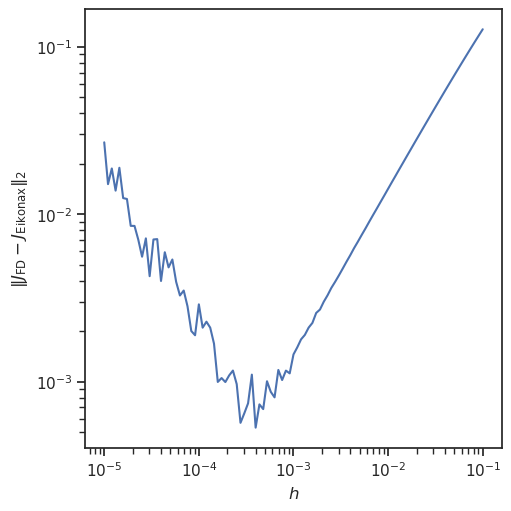

In [6]:
eikonax_jacobian = derivator.compute_eikonax_jacobian(derivative_solver, sparse_partial_parameter)

step_widths = np.logspace(-5, -1, 101)
errors = []
for step_width in step_widths:
    finite_diff_jacobian = finite_diff.compute_fd_jacobian(
        eikonax_solver=eikonal_solver,
        tensor_field=tensor_field,
        stencil=finite_diff.finite_diff_1_forward,
        eval_point=parameter_vector,
        step_width=step_width,
    )
    error = np.linalg.norm(finite_diff_jacobian - eikonax_jacobian)
    errors.append(error)

fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
ax.set_xlabel(r"$h$")
ax.set_ylabel(r"$\|J_{\text{FD}} - J_{\text{Eikonax}}\|_2$")
ax.loglog(step_widths, errors)